# Distribution Shift Detection Exploration

In the realm of machine learning and deep learning, understanding and detecting shifts in data distributions is crucial for maintaining model performance and robustness. In this notebook, we will showcase how to leverage our distribution shift detector, as presented in our research. This walkthrough will provide insights into the practical application of the detector, ensuring that practitioners can effectively utilize it in real-world scenarios.


## Model Initialization

For our demonstration, we will employ the ResNet20 architecture, a renowned deep learning model known for its performance on image datasets. Specifically, we'll utilize a pretrained version of this model suitable for the CIFAR10 dataset.

**Reference Repository**: [chenyaofo/pytorch-cifar-models](https://github.com/chenyaofo/pytorch-cifar-models)


In [1]:
import torch

# Setting a random seed for reproducibility
torch.manual_seed(0)

# Determining the execution device (CPU or CUDA)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Loading a pretrained ResNet20 model for CIFAR10
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = model.to(device)
model.eval()  # Setting the model to evaluation mode


Using cache found in /home/guy.b/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

## Uncertainty Estimator Initialization

To quantify uncertainty in our predictions, we need to define an uncertainty mechanism. In our framework, we currently support two primary mechanisms:
1. Softmax Response (SR)
2. Entropy (Ent)

For this demonstration, we will use the 'Ent' mechanism.


In [2]:
# Choosing an uncertainty mechanism for predictions
uncertainty_mechanism = 'Ent'  # Using 'Entropy' as the mechanism


## Setting Detector Parameters

The performance of the distribution shift detector is influenced by a set of hyperparameters. Based on extensive evaluations presented in our paper, we have identified optimal values for these hyperparameters. Here, we'll set them accordingly:
- $ C_{\text{target}} $: Represents the number of target coverages.
- $\delta $: The confidence parameter for each SGC/SGC-UP.

In [3]:
# Setting hyperparameters for the distribution shift detector

# Number of target coverages
C_target = 10

# Confidence parameter for each SGC/SGC-UP
delta = 0.001


> **Note for Real-world Applications**: It's essential to set an appropriate confidence parameter, $\alpha$. If the computed p-value is less than $\alpha$, it indicates a potential distribution shift. Typically, a value of $\alpha = 0.05$ is considered, but users can adjust it based on their requirements.


In [4]:
# Setting the confidence threshold for detecting distribution shifts
alpha = 0.05  # Typically used threshold value


## Fitting the Detector

To demonstrate the efficacy of our distribution shift detector, we will conduct a simulation experiment. In this setup:
- **In-Distribution Samples**: Derived from the CIFAR10 test set.
- **Out-Of-Distribution Samples**: Derived from the CIFAR100 test set.

This experimental design allows us to emulate real-world scenarios, including cases with no shift and cases with evident distribution changes.


##### Inferencing CIFAR10 to Obtain Logits

In [5]:
# Import required libraries and modules
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the device for computation (either CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define transformations for preprocessing the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201]),
])

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)

# Set the model to evaluation mode
model.eval()

# Initialize counters for correct predictions and total samples
correct = 0
total = 0

# List to store logits for all test samples
cifar10_logits = []

# Evaluate the model on the CIFAR-10 test dataset
with torch.no_grad():
    for data in tqdm(testloader, desc="Evaluating CIFAR-10"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Store logits for the current batch
        cifar10_logits.append(outputs.cpu())
        
        # Compute the number of correct predictions for the current batch
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Concatenate logits from all batches
cifar10_logits = torch.cat(cifar10_logits, dim=0)

# Compute the overall accuracy on the CIFAR-10 test dataset
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")
print(f'{cifar10_logits.shape=}')


Files already downloaded and verified


Evaluating CIFAR-10: 100%|██████████| 40/40 [00:01<00:00, 30.02it/s]

Accuracy: 92.60%
cifar10_logits.shape=torch.Size([10000, 10])


### Splitting CIFAR10 Data

To simulate real-world scenarios in our detection experiment, we need a mix of training (or fitting) data and validation data. The fitting data is utilized to calibrate the detector, while the validation data tests for potential distribution shifts.

For this demonstration, we'll evenly split the CIFAR10 dataset (consisting of 10,000 samples) into:
- `fit_data`: 5,000 samples used for calibration.
- `validation_data`: 5,000 samples to test the no-shift case, where both fitting and validation samples originate from the same distribution.
"""

In [6]:
# Create a random permutation of indices
indices = torch.randperm(cifar10_logits.size(0))

# Split the indices into two halves
half_size = cifar10_logits.size(0) // 2
indices_1 = indices[:half_size]
indices_2 = indices[half_size:]

# Use the indices to split the logits
fit_data = cifar10_logits[indices_1]
validation_data = cifar10_logits[indices_2]

# Display the shape of the split data
print(f'{fit_data.shape=}')
print(f'{validation_data.shape=}')

fit_data.shape=torch.Size([5000, 10])
validation_data.shape=torch.Size([5000, 10])


## Fitting the Distribution Shift Detector

In this section, we will walk through the process of fitting our distribution shift detector. This process can be summarized in the following steps:

1. **Initialization**: Begin by setting up the detector with the desired parameters.
2. **Fitting**: Utilize the `fit_data` to fit the detector.

Let's dive into the implementation.

In [7]:
from shift_detection import *
my_detector = CBD(c_num=C_target, delta=delta, uncertainty_mechanism=uncertainty_mechanism)
result_dicts = my_detector.fit(fit_data)

## Evaluating the No-Shift Scenario with CIFAR10

In this section, we will apply our distribution shift detector to the `validation_data` from the CIFAR10 dataset. Given that this data comes from the same distribution:

- We anticipate that all the set bounds will be respected.
- A notable observation: If all bounds are maintained (indicating no shift detection), the returned p-value is automatically set to 1.

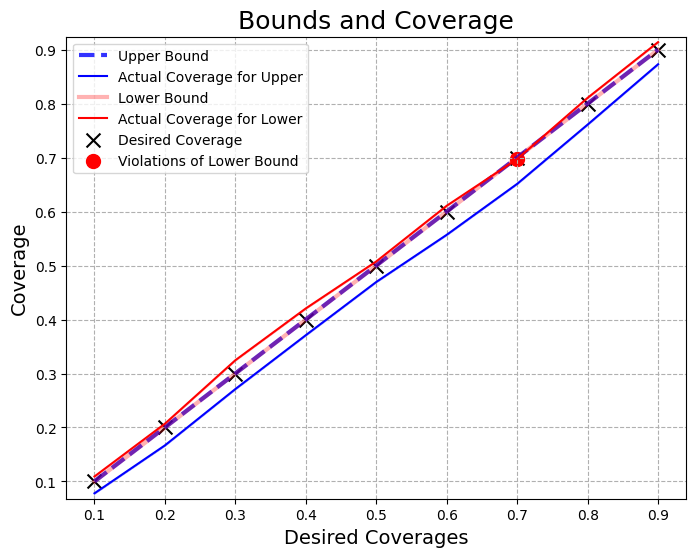

##### Under Confidence Shift #####
P-value: 0.3486
No shift detected.
##################################
##### Over Confidence Shift #####
P-value: 1.0000
No shift detected.
#################################


In [8]:
result_dicts = my_detector.detect(validation_data)
# print_nested_dict(result_dicts)
result_dicts = edict(result_dicts)
p_value_lower = result_dicts.p_value_lower
p_value_upper = result_dicts.p_value_upper
plot_bounds(upper_bounds=[result_dicts.coverage_upper_bounds],
                lower_bounds=[result_dicts.coverage_lower_bounds],
                actual_coverage_for_lower=[result_dicts.actual_coverages_lower],
                actual_coverage_for_upper=[result_dicts.actual_coverages_upper],
                desired_coverages=result_dicts.desired_coverages)
print_p_value_info(p_value_lower, alpha=alpha, bound='lower')
print_p_value_info(p_value_upper, alpha=alpha, bound='upper')

## Evaluating the Shift Using CIFAR100

In this segment, we will assess the potential distribution shift using CIFAR100 as our proxy dataset. Based on our prior knowledge and expectations, a shift in distribution should be observable. Our evaluation will involve:

1. **Inference**: Running our model on the CIFAR100 dataset.
2. **Accuracy Assessment**: Analyzing the expected drop in accuracy due to the distribution shift.
"""

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

# Define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the transform to preprocess the data
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201]),
])

# Load the CIFAR-100 dataset
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=2)

model.eval()
correct = 0
total = 0

# Create a list to store all output logits
cifar100_logits = []

with torch.no_grad():
    for data in tqdm(testloader, desc="Evaluating CIFAR-100"):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        # Append the outputs of the current batch to the all_outputs list
        cifar100_logits.append(outputs.cpu())
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Concatenate all outputs
cifar100_logits = torch.cat(cifar100_logits, dim=0)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")
print(f'{cifar100_logits.shape=}')


Files already downloaded and verified


Evaluating CIFAR-100: 100%|██████████| 40/40 [00:00<00:00, 45.52it/s]

Accuracy: 0.87%
cifar100_logits.shape=torch.Size([10000, 10])


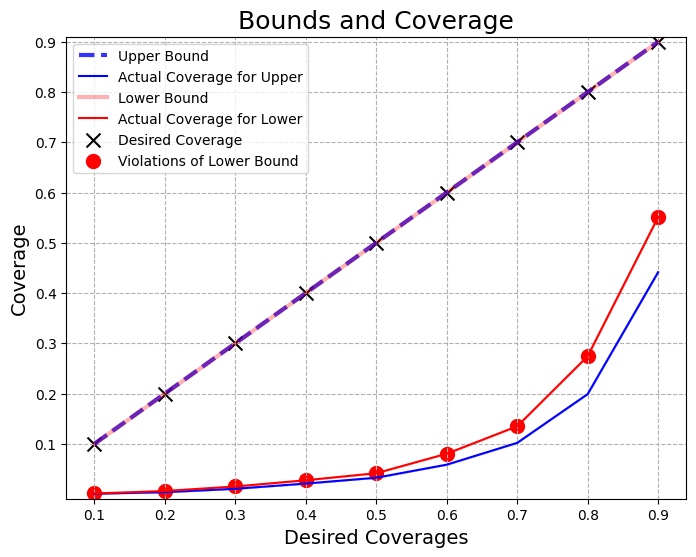

##### Under Confidence Shift #####
P-value: 0.0000
Shift detected!
##################################
##### Over Confidence Shift #####
P-value: 1.0000
No shift detected.
#################################


In [10]:
effective_window_size = 5000
assert (effective_window_size < len(cifar100_logits)), "The window size must be smaller than the size of CIFAR100 test set."
cifar100_logits = cifar100_logits[:effective_window_size]
result_dicts = my_detector.detect(cifar100_logits)
# print_nested_dict(result_dicts)
result_dicts = edict(result_dicts)
p_value_lower = result_dicts.p_value_lower
p_value_upper = result_dicts.p_value_upper
plot_bounds(upper_bounds=[result_dicts.coverage_upper_bounds],
                lower_bounds=[result_dicts.coverage_lower_bounds],
                actual_coverage_for_lower=[result_dicts.actual_coverages_lower],
                actual_coverage_for_upper=[result_dicts.actual_coverages_upper],
                desired_coverages=result_dicts.desired_coverages)
print_p_value_info(p_value_lower, alpha=alpha, bound='lower')
print_p_value_info(p_value_upper, alpha=alpha, bound='upper')


## Simulating the Over-Confidence Shift

From our previous evaluations, the model exhibited **under-confidence** when tested against the CIFAR100 dataset. To emulate a scenario of **over-confidence shift**:
- We will adjust the $ \kappa $ values for the CIFAR10 dataset.
- This modification will induce the model to exhibit heightened confidence in its predictions, thereby simulating the desired shift.

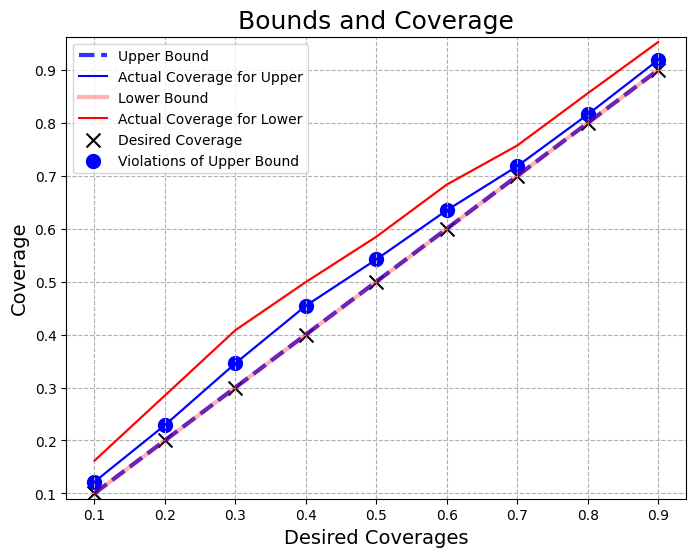

##### Under Confidence Shift #####
P-value: 1.0000
No shift detected.
##################################
##### Over Confidence Shift #####
P-value: 0.0000
Shift detected!
#################################


In [11]:
def increase_max_by_epsilon(matrix: torch.Tensor, epsilon: float) -> torch.Tensor:
    """
    Increase the maximum value in each row of the given matrix by epsilon.

    :param matrix: Input tensor of shape (N, C)
    :param epsilon: Value to increase the max by
    :return: Modified tensor
    """
    # For each row, find the maximum's index and increase by epsilon
    max_indices = torch.argmax(matrix, dim=1)  # Find index of max in each row
    rows = torch.arange(matrix.size(0))
    matrix[rows, max_indices] += epsilon
    
    return matrix

cifar_over_confidence = increase_max_by_epsilon(cifar10_logits, epsilon=1)
cifar_over_confidence = cifar_over_confidence[:effective_window_size]
result_dicts = my_detector.detect(cifar_over_confidence)
# print_nested_dict(result_dicts)
result_dicts = edict(result_dicts)
p_value_lower = result_dicts.p_value_lower
p_value_upper = result_dicts.p_value_upper
plot_bounds(upper_bounds=[result_dicts.coverage_upper_bounds],
                lower_bounds=[result_dicts.coverage_lower_bounds],
                actual_coverage_for_lower=[result_dicts.actual_coverages_lower],
                actual_coverage_for_upper=[result_dicts.actual_coverages_upper],
                desired_coverages=result_dicts.desired_coverages)
print_p_value_info(p_value_lower, alpha=alpha, bound='lower')
print_p_value_info(p_value_upper, alpha=alpha, bound='upper')